# Honeypot attacks exploration

## Loading data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import glob
import os
import datetime
import IP2Location
import geoip2.database
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import chisquare
%matplotlib inline

In [2]:
# データを読み込む　
# load data
cols = ['date', 'time', 'access_ip', 'host_ip', 'request_line', 'status_code', 'match_result', 'request_all']
df = pd.DataFrame()
for filename in glob.glob('data/*.txt'):
    df_new = pd.read_csv(filename, sep = ' ', header = None, names = cols, parse_dates = True)
    df = pd.concat([df, df_new])

## Assessing and cleaning data

In [3]:
# データのはじめの５行を表示する 
# show first 5 rows
df.head()

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all
0,[2020-03-01,00:01:37+0900],134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...
1,[2020-03-01,00:01:38+0900],134.209.184.77,closedbeta.net:80,POST /blog/closedbeta.net/blog/wp-login.php HT...,200,1011,UE9TVCAvYmxvZy9jbG9zZWRiZXRhLm5ldC9ibG9nL3dwLW...
2,[2020-03-01,00:11:53+0900],193.106.30.99,closedbeta.net:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKSG9zdDogY2xvc2VkYmV0YS5uZX...
3,[2020-03-01,00:19:47+0900],165.22.222.119,closedbeta.net:80,POST /code.conflicts.php HTTP/1.1,200,1037,UE9TVCAvY29kZS5jb25mbGljdHMucGhwIEhUVFAvMS4xCk...
4,[2020-03-01,00:19:55+0900],189.240.124.61,closedbeta.net:80,POST /work.clases.php HTTP/1.1,200,1037,UE9TVCAvd29yay5jbGFzZXMucGhwIEhUVFAvMS4xCkFjY2...


In [4]:
# size of the dataset
df.shape

(563883, 8)

In [5]:
# basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563883 entries, 0 to 199532
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   date          563883 non-null  object
 1   time          563883 non-null  object
 2   access_ip     563883 non-null  object
 3   host_ip       563883 non-null  object
 4   request_line  563883 non-null  object
 5   status_code   563883 non-null  int64 
 6   match_result  563883 non-null  object
 7   request_all   563883 non-null  object
dtypes: int64(1), object(7)
memory usage: 38.7+ MB


No missing values. 欠損値がない

In [6]:
# check duplicates　重複した値（あたい
df.duplicated().sum()

499

重複した値は４９９行あります

In [7]:
# duplicated records
df[df.duplicated()]

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all
962,[2020-03-02,12:50:29+0900],81.180.119.230,blank:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKCg==
1481,[2020-03-03,02:22:23+0900],178.128.23.112,closedbeta.net:80,GET /wp-admin/profile.php HTTP/1.1,200,False,R0VUIC93cC1hZG1pbi9wcm9maWxlLnBocCBIVFRQLzEuMQ...
1597,[2020-03-03,04:41:51+0900],100.11.48.113,blank:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKCg==
1599,[2020-03-03,04:41:52+0900],100.11.48.113,blank:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKCg==
1886,[2020-03-03,17:26:31+0900],142.93.87.106,closedbeta.net:80,GET / HTTP/1.0,200,False,R0VUIC8gSFRUUC8xLjAKSG9zdDogY2xvc2VkYmV0YS5uZX...
...,...,...,...,...,...,...,...,...
197143,[2020-06-29,01:44:35+0900],62.210.180.62,mta-sts.closedbeta.net:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKSG9zdDogbXRhLXN0cy5jbG9zZW...
197256,[2020-06-29,03:03:34+0900],62.210.172.100,backup.closedbeta.net:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKSG9zdDogYmFja3VwLmNsb3NlZG...
197718,[2020-06-29,07:13:32+0900],111.231.200.218,120.51.157.176:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKQWNjZXB0OiAqLyoKQWNjZXB0LU...
198037,[2020-06-29,11:31:18+0900],62.210.141.218,backup.closedbeta.net:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKSG9zdDogYmFja3VwLmNsb3NlZG...


In [8]:
# take a look at one of the duplicated records
df[(df.time == '12:50:29+0900') & (df.access_ip == '81.180.119.230')]

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all


In [9]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [10]:
# double check duplicates
df.duplicated().sum()

0

In [11]:
# clean the date column
df['date'] = df.date.str.lstrip('[')
df.head()

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all
0,2020-03-01,00:01:37+0900],134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...
1,2020-03-01,00:01:38+0900],134.209.184.77,closedbeta.net:80,POST /blog/closedbeta.net/blog/wp-login.php HT...,200,1011,UE9TVCAvYmxvZy9jbG9zZWRiZXRhLm5ldC9ibG9nL3dwLW...
2,2020-03-01,00:11:53+0900],193.106.30.99,closedbeta.net:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKSG9zdDogY2xvc2VkYmV0YS5uZX...
3,2020-03-01,00:19:47+0900],165.22.222.119,closedbeta.net:80,POST /code.conflicts.php HTTP/1.1,200,1037,UE9TVCAvY29kZS5jb25mbGljdHMucGhwIEhUVFAvMS4xCk...
4,2020-03-01,00:19:55+0900],189.240.124.61,closedbeta.net:80,POST /work.clases.php HTTP/1.1,200,1037,UE9TVCAvd29yay5jbGFzZXMucGhwIEhUVFAvMS4xCkFjY2...


In [12]:
# clean the time column
df['time'] = df.time.str.rstrip(']')
df.head()

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...
1,2020-03-01,00:01:38+0900,134.209.184.77,closedbeta.net:80,POST /blog/closedbeta.net/blog/wp-login.php HT...,200,1011,UE9TVCAvYmxvZy9jbG9zZWRiZXRhLm5ldC9ibG9nL3dwLW...
2,2020-03-01,00:11:53+0900,193.106.30.99,closedbeta.net:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKSG9zdDogY2xvc2VkYmV0YS5uZX...
3,2020-03-01,00:19:47+0900,165.22.222.119,closedbeta.net:80,POST /code.conflicts.php HTTP/1.1,200,1037,UE9TVCAvY29kZS5jb25mbGljdHMucGhwIEhUVFAvMS4xCk...
4,2020-03-01,00:19:55+0900,189.240.124.61,closedbeta.net:80,POST /work.clases.php HTTP/1.1,200,1037,UE9TVCAvd29yay5jbGFzZXMucGhwIEhUVFAvMS4xCkFjY2...


## Feture engineering

### month, day, hour_JP

In [13]:
# extract month, day from date
df['month'] = df['date'].apply(lambda x: x[5:7]).astype(int)
month_dict = {1: 'Janurary', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August'}
df['month'] = df.month.map(month_dict)
df['day'] = df['date'].apply(lambda x: x[8:10]).astype(int)
df.head()

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1
1,2020-03-01,00:01:38+0900,134.209.184.77,closedbeta.net:80,POST /blog/closedbeta.net/blog/wp-login.php HT...,200,1011,UE9TVCAvYmxvZy9jbG9zZWRiZXRhLm5ldC9ibG9nL3dwLW...,March,1
2,2020-03-01,00:11:53+0900,193.106.30.99,closedbeta.net:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKSG9zdDogY2xvc2VkYmV0YS5uZX...,March,1
3,2020-03-01,00:19:47+0900,165.22.222.119,closedbeta.net:80,POST /code.conflicts.php HTTP/1.1,200,1037,UE9TVCAvY29kZS5jb25mbGljdHMucGhwIEhUVFAvMS4xCk...,March,1
4,2020-03-01,00:19:55+0900,189.240.124.61,closedbeta.net:80,POST /work.clases.php HTTP/1.1,200,1037,UE9TVCAvd29yay5jbGFzZXMucGhwIEhUVFAvMS4xCkFjY2...,March,1


In [14]:
# extract hour from time (JP local time)
df['hour_JP'] = df['time'].apply(lambda x: x[0:2]).astype(int)
df.head()

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,hour_JP
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,0
1,2020-03-01,00:01:38+0900,134.209.184.77,closedbeta.net:80,POST /blog/closedbeta.net/blog/wp-login.php HT...,200,1011,UE9TVCAvYmxvZy9jbG9zZWRiZXRhLm5ldC9ibG9nL3dwLW...,March,1,0
2,2020-03-01,00:11:53+0900,193.106.30.99,closedbeta.net:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKSG9zdDogY2xvc2VkYmV0YS5uZX...,March,1,0
3,2020-03-01,00:19:47+0900,165.22.222.119,closedbeta.net:80,POST /code.conflicts.php HTTP/1.1,200,1037,UE9TVCAvY29kZS5jb25mbGljdHMucGhwIEhUVFAvMS4xCk...,March,1,0
4,2020-03-01,00:19:55+0900,189.240.124.61,closedbeta.net:80,POST /work.clases.php HTTP/1.1,200,1037,UE9TVCAvd29yay5jbGFzZXMucGhwIEhUVFAvMS4xCkFjY2...,March,1,0


### country, country_code, ip_country

In [15]:
# load the IP2Location database
database = IP2Location.IP2Location(os.path.join("data", "IP2LOCATION-LITE-DB11.IPV6.BIN"))

In [16]:
# map ip to country
df['country'] = df.access_ip.apply(lambda ip: database.get_all(ip).country_long)
df.head(1)

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,hour_JP,country
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,0,United Kingdom of Great Britain and Northern I...


In [17]:
# map ip to country
df['country_code'] = df.access_ip.apply(lambda ip: database.get_all(ip).country_short)
df.head(1)

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,hour_JP,country,country_code
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,0,United Kingdom of Great Britain and Northern I...,GB


In [18]:
# combine ip with the country code
df['ip_country'] = df['access_ip'] + '-' + df['country_code']
df.head(1)

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,hour_JP,country,country_code,ip_country
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,0,United Kingdom of Great Britain and Northern I...,GB,134.209.184.77-GB


### region, city

In [19]:
# map ip to region
df['region'] = df.access_ip.apply(lambda ip: database.get_all(ip).region)
df.head(1)

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,hour_JP,country,country_code,ip_country,region
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,0,United Kingdom of Great Britain and Northern I...,GB,134.209.184.77-GB,England


In [20]:
# map ip to city
df['city'] = df.access_ip.apply(lambda ip: database.get_all(ip).city)
df.head(1)

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,hour_JP,country,country_code,ip_country,region,city
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,0,United Kingdom of Great Britain and Northern I...,GB,134.209.184.77-GB,England,London


### latitude, longitude

In [21]:
# get the latitude and longitude of the IP
df['latitude'] = df.access_ip.apply(lambda ip: database.get_all(ip).latitude)
df['longitude'] = df.access_ip.apply(lambda ip: database.get_all(ip).longitude)
df.head(1)

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,hour_JP,country,country_code,ip_country,region,city,latitude,longitude
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,0,United Kingdom of Great Britain and Northern I...,GB,134.209.184.77-GB,England,London,51.50853,-0.12574


### timezone, hour_Local

In [22]:
# get the time zone of ip
df['timezone'] = df.access_ip.apply(lambda ip: database.get_all(ip).timezone)
df.head(1)

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,hour_JP,country,country_code,ip_country,region,city,latitude,longitude,timezone
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,0,United Kingdom of Great Britain and Northern I...,GB,134.209.184.77-GB,England,London,51.50853,-0.12574,+01:00


In [23]:
# value_count of timezone
df.timezone.value_counts()

+02:00    182316
+01:00    111136
-04:00     64332
+08:00     54145
+03:00     49384
-07:00     42550
+07:00     13849
+05:30     12915
-05:00     12372
+09:00      5956
-06:00      5001
-03:00      3350
+10:00      3341
+04:30      1259
+05:00       709
+04:00       311
+06:00       268
+05:45        90
+09:30        38
+00:00        24
+12:00        21
+06:30        10
+11:00         4
-              1
-10:00         1
-08:00         1
Name: timezone, dtype: int64

In [24]:
# drop the record with a value '-' for timezone
df = df[df.timezone != '-']
df.timezone.value_counts()

+02:00    182316
+01:00    111136
-04:00     64332
+08:00     54145
+03:00     49384
-07:00     42550
+07:00     13849
+05:30     12915
-05:00     12372
+09:00      5956
-06:00      5001
-03:00      3350
+10:00      3341
+04:30      1259
+05:00       709
+04:00       311
+06:00       268
+05:45        90
+09:30        38
+00:00        24
+12:00        21
+06:30        10
+11:00         4
-10:00         1
-08:00         1
Name: timezone, dtype: int64

In [25]:
# extract only the integer of the timezone
df['timezone'] = df.timezone.apply(lambda x: int(x.split(':')[0]))

In [26]:
# define a function to get the local time
def get_local_hour(hour_JP, timezone, timezone_JP=9):
    """
    this function get the local hour from hour in JP, timezone in JP and local timezone

    input arguments:

    hour_JP: the hour in JP
    timezone: the local timezone
    timezoneJP: the timezone in Japan, default, 9

    return:

    the hour in local time
    """
    local_hour = hour_JP - (timezone_JP - timezone)
    if local_hour < 0:
        local_hour += 24
    elif local_hour > 24:
        local_hour -= 24
    return local_hour
     

In [27]:
# test the get_local_hour function
get_local_hour(13, 8) == 12, get_local_hour(13, 0) == 4, get_local_hour(13, -5) == 23


(True, True, True)

In [28]:
# apply the get_local_hour function to the dataframe to get the local hour of the access
df['hour_Local'] = df.apply(lambda x: get_local_hour(x['hour_JP'], x['timezone']), axis=1)
df.head()

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,hour_JP,country,country_code,ip_country,region,city,latitude,longitude,timezone,hour_Local
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,0,United Kingdom of Great Britain and Northern I...,GB,134.209.184.77-GB,England,London,51.508530,-0.125740,1,16
1,2020-03-01,00:01:38+0900,134.209.184.77,closedbeta.net:80,POST /blog/closedbeta.net/blog/wp-login.php HT...,200,1011,UE9TVCAvYmxvZy9jbG9zZWRiZXRhLm5ldC9ibG9nL3dwLW...,March,1,0,United Kingdom of Great Britain and Northern I...,GB,134.209.184.77-GB,England,London,51.508530,-0.125740,1,16
2,2020-03-01,00:11:53+0900,193.106.30.99,closedbeta.net:80,GET / HTTP/1.1,200,False,R0VUIC8gSFRUUC8xLjEKSG9zdDogY2xvc2VkYmV0YS5uZX...,March,1,0,Ukraine,UA,193.106.30.99-UA,Kyiv,Kiev,50.454659,30.523800,3,18
3,2020-03-01,00:19:47+0900,165.22.222.119,closedbeta.net:80,POST /code.conflicts.php HTTP/1.1,200,1037,UE9TVCAvY29kZS5jb25mbGljdHMucGhwIEhUVFAvMS4xCk...,March,1,0,India,IN,165.22.222.119-IN,Karnataka,Bengaluru,12.976230,77.603287,5,20
4,2020-03-01,00:19:55+0900,189.240.124.61,closedbeta.net:80,POST /work.clases.php HTTP/1.1,200,1037,UE9TVCAvd29yay5jbGFzZXMucGhwIEhUVFAvMS4xCkFjY2...,March,1,0,Mexico,MX,189.240.124.61-MX,Ciudad de Mexico,Mexico City,19.428471,-99.127663,-5,10


### method, http_version

In [29]:
# create a method column from request_line
df['method'] = df['request_line'].apply(lambda x: x.split(' ')[0])
df.head(1)

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,...,country,country_code,ip_country,region,city,latitude,longitude,timezone,hour_Local,method
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,...,United Kingdom of Great Britain and Northern I...,GB,134.209.184.77-GB,England,London,51.50853,-0.12574,1,16,GET


In [30]:
# get the HTTP version from request_line
df['http_version'] = df['request_line'].apply(lambda x: x.split(' ')[-1])
df.head(1)

,date,time,access_ip,host_ip,request_line,status_code,match_result,request_all,month,day,...,country_code,ip_country,region,city,latitude,longitude,timezone,hour_Local,method,http_version
0,2020-03-01,00:01:37+0900,134.209.184.77,closedbeta.net:80,GET /blog/wp-login.php HTTP/1.1,200,1011,R0VUIC9ibG9nL3dwLWxvZ2luLnBocCBIVFRQLzEuMQpIb3...,March,1,...,GB,134.209.184.77-GB,England,London,51.50853,-0.12574,1,16,GET,HTTP/1.1


## Exploratory Data Analysis

### date

In [31]:
# convert the data type of date from object to datetime
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563383 entries, 0 to 199532
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          563383 non-null  datetime64[ns]
 1   time          563383 non-null  object        
 2   access_ip     563383 non-null  object        
 3   host_ip       563383 non-null  object        
 4   request_line  563383 non-null  object        
 5   status_code   563383 non-null  int64         
 6   match_result  563383 non-null  object        
 7   request_all   563383 non-null  object        
 8   month         563383 non-null  object        
 9   day           563383 non-null  int64         
 10  hour_JP       563383 non-null  int64         
 11  country       563383 non-null  object        
 12  country_code  563383 non-null  object        
 13  ip_country    563383 non-null  object        
 14  region        563383 non-null  object        
 15  city          563

In [32]:
# value counts of date
df.date.value_counts()

2020-06-21    85576
2020-06-20    56174
2020-06-12    19784
2020-08-28    16822
2020-07-23    16404
              ...  
2020-01-17      248
2020-05-06      233
2020-08-04      208
2020-01-30      189
2020-01-16      176
Name: date, Length: 244, dtype: int64

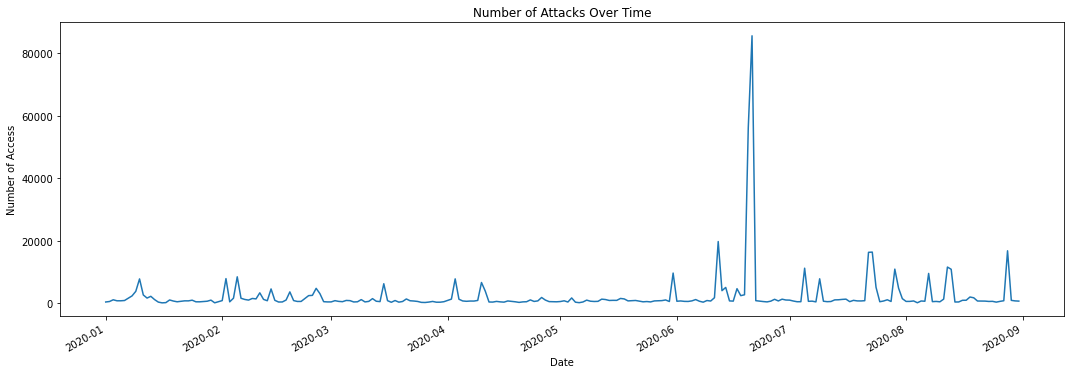

In [33]:
# line plot of access trend over time
plt.figure(figsize=(18,6))
df.date.value_counts().plot()
plt.xlabel('Date')
plt.ylabel('Number of Access')
plt.title('Number of Attacks Over Time')
plt.savefig('plot/1.pdf');



### access_ip

In [34]:
# value counts
df.access_ip.value_counts()

185.234.216.28     45191
185.234.217.39     42428
193.106.30.99      37926
193.169.252.37     37913
80.82.70.206       10444
                   ...  
95.27.223.221          1
188.119.30.82          1
154.117.181.78         1
35.162.155.9           1
187.120.148.154        1
Name: access_ip, Length: 16173, dtype: int64

In [35]:
# number of unique access ip
print('There are {} IPs in in total'.format(df.access_ip.nunique()))

There are 16173 IPs in in total


### request_line

In [36]:
# value counts

df.request_line.value_counts()

POST /wp-login.php HTTP/1.1                                                                                                  193835
GET /wp-login.php HTTP/1.1                                                                                                    37142
POST /xmlrpc.php HTTP/1.1                                                                                                     28058
GET /manager/html HTTP/1.1                                                                                                    14531
GET / HTTP/1.1                                                                                                                12889
                                                                                                                              ...  
GET /blog/closedbeta.net/blog/?author=123 HTTP/1.1                                                                                1
GET /index.php/index/ajaxlogin.shtml HTTP/1.1                               

### status_code

In [37]:
# value counts
df.status_code.value_counts()

200    548833
401     14531
201        19
Name: status_code, dtype: int64

### match_result

In [38]:
# value count
df.match_result.value_counts()

1011     368791
False    123234
1037      48448
1032      14531
1003       5841
1006       1262
1007        595
1001        238
1002        123
1039        103
1020         68
1023         48
1004         45
1005         19
1010         13
1017         11
1022          5
1019          4
1035          2
1043          1
1015          1
Name: match_result, dtype: int64

### month

In [39]:
# value count
df.month.value_counts()

June        199458
July         92949
August       70421
February     61030
Janurary     39049
April        38870
May          35046
March        26560
Name: month, dtype: int64

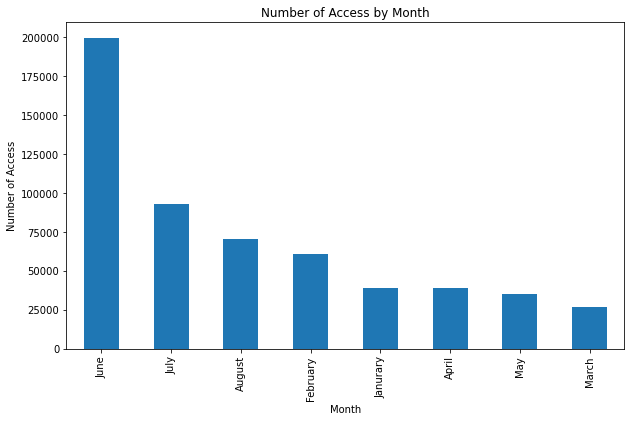

In [40]:
# bar chart
plt.figure(figsize=(10,6))
df.month.value_counts().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Access')
plt.title('Number of Access by Month');

### day

In [41]:
# value count
df.day.value_counts()

21    91314
20    60959
12    38334
5     24288
23    22526
13    21575
28    21556
22    21492
10    19017
9     17716
29    16827
7     15562
11    15055
14    14705
2     13793
31    13026
3     12559
24    11752
15    11702
19    11499
18    10685
26    10440
17     9712
27     9381
30     8449
4      7508
8      7209
6      6950
25     6103
16     5950
1      5739
Name: day, dtype: int64

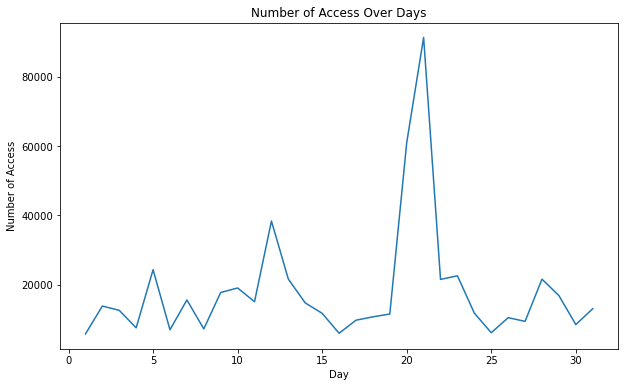

In [42]:
# plot of Number of Access Over Days
df_day = df.day.value_counts().reset_index()
df_day.columns = ['day', 'count']
plt.figure(figsize=(10, 6))
sns.lineplot(x='day', y='count', data=df_day)
plt.xlabel('Day')
plt.ylabel('Number of Access')
plt.title('Number of Access Over Days');

### hour_JP 

In [43]:
# value count
df.hour_JP.value_counts()

10    39794
14    36527
2     31504
11    30383
13    29750
16    29630
12    28561
15    27672
3     26112
1     25187
18    24627
4     23501
9     22969
17    22969
0     21718
8     20764
5     16825
6     16174
7     15795
22    15691
19    15516
21    15502
20    15008
23    11204
Name: hour_JP, dtype: int64

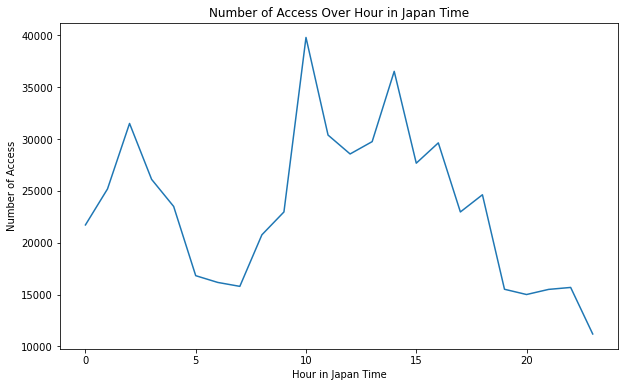

In [44]:
# plot of number of access over hour in japan time
df_hour_JP = df.hour_JP.value_counts().reset_index()
df_hour_JP.columns = ['hour_JP', 'count']
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour_JP', y='count', data=df_hour_JP)
plt.xlabel('Hour in Japan Time')
plt.ylabel('Number of Access')
plt.title('Number of Access Over Hour in Japan Time');

### hour_Local

In [45]:
# value count
df.hour_Local.value_counts()

6     30588
20    30482
4     30063
21    28853
19    27217
7     27014
5     26482
8     26408
18    25372
12    25014
17    24561
0     24339
2     24003
3     23993
1     22885
9     21935
13    21567
16    20280
22    19494
10    18434
15    17333
14    17058
23    14959
11    14949
24      100
Name: hour_Local, dtype: int64

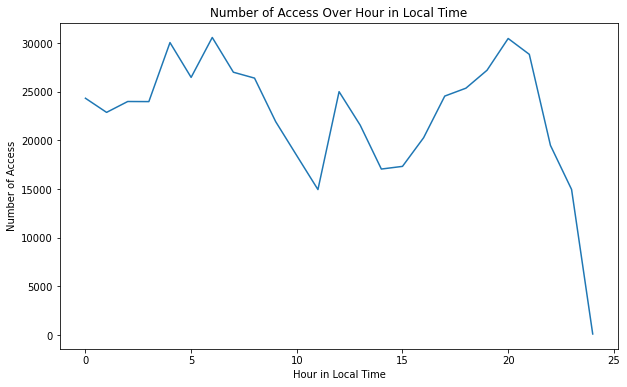

In [46]:
# plot of number of access over hour in local time
df_hour_Local = df.hour_Local.value_counts().reset_index()
df_hour_Local.columns = ['hour_Local', 'count']
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour_Local', y='count', data=df_hour_Local)
plt.xlabel('Hour in Local Time')
plt.ylabel('Number of Access')
plt.title('Number of Access Over Hour in Local Time');

### country

In [47]:
# value counts
df.country.value_counts()

United States of America    108978
Ireland                      91565
France                       44303
Netherlands                  42770
Poland                       41847
                             ...  
Martinique                       1
Mali                             1
Senegal                          1
Burkina Faso                     1
Oman                             1
Name: country, Length: 147, dtype: int64

In [48]:
# unique values
df.country.unique()

array(['United Kingdom of Great Britain and Northern Ireland', 'Ukraine',
       'India', 'Mexico', 'Singapore', 'United States of America',
       'France', 'Germany', 'China', 'Thailand', 'Russian Federation',
       'Hungary', 'Turkey', 'Hong Kong', 'Brazil', 'Indonesia', 'Canada',
       'Iran (Islamic Republic of)', 'Argentina', 'Netherlands',
       'Switzerland', 'Japan', 'Bulgaria', 'Ireland', 'Czechia',
       'South Africa', 'Bangladesh', 'Romania', 'Poland', 'Australia',
       'Malaysia', 'Bosnia and Herzegovina', 'Belgium', 'Viet Nam',
       'Spain', 'Chile', 'Eswatini', 'Austria', "Cote D'ivoire",
       'Denmark', 'Italy', 'Taiwan (Province of China)', 'Latvia',
       'Venezuela (Bolivarian Republic of)', 'Ecuador', 'Luxembourg',
       'Sri Lanka', 'Morocco', 'Lithuania', 'Israel',
       'Korea (Republic of)', 'Montenegro', 'Cameroon', 'Belize', 'Nepal',
       'Pakistan', 'Cambodia', 'Sweden',
       'Bolivia (Plurinational State of)', 'Greece', 'Solomon Islands',
 

In [49]:
# top 10 country
df_country = df.country.value_counts().reset_index()
df_country.columns = ['country', 'count']
top10_country = df_country.iloc[0:10, ]
top10_country.at[0, 'country'] = 'US'
top10_country.at[9, 'country'] = 'UK'
top10_country

,country,count
0,US,108978
1,Ireland,91565
2,France,44303
3,Netherlands,42770
4,Poland,41847
5,Ukraine,39682
6,Germany,26578
7,China,24729
8,Singapore,22071
9,UK,18940


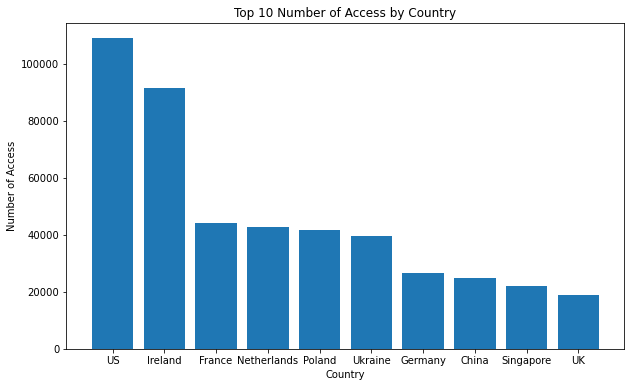

In [50]:
# plot of top 10 number of access by country
plt.figure(figsize=(10,6))
plt.bar(x = top10_country['country'], height = top10_country['count'])
plt.xlabel('Country')
plt.ylabel('Number of Access')
plt.title('Top 10 Number of Access by Country');


### region

In [51]:
# value count

df.region.value_counts()

Cork             88017
Wielkopolskie    38041
Kyiv             37985
Zuid-Holland     31603
New Jersey       31104
                 ...  
Ilfov                1
Lampang              1
Kardzhali            1
Guadeloupe           1
Manitoba             1
Name: region, Length: 1013, dtype: int64

In [52]:
# number of unique regions

df.region.nunique()

1013

In [53]:
# top 10 region
df_region = df.region.value_counts().reset_index()
df_region.columns = ['region', 'count']
top10_region = df_region.iloc[0:10, ]
top10_region

,region,count
0,Cork,88017
1,Wielkopolskie,38041
2,Kyiv,37985
3,Zuid-Holland,31603
4,New Jersey,31104
5,Hauts-de-France,26217
6,California,22654
7,Singapore,22071
8,England,18927
9,Hessen,17976


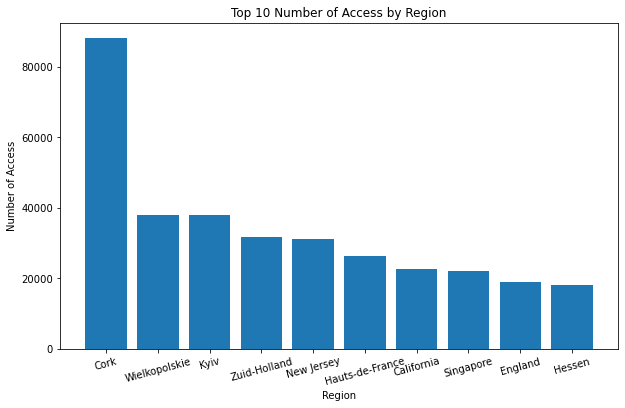

In [54]:
# plot of top 10 number of access by region
plt.figure(figsize=(10,6))
plt.bar(x = top10_region['region'], height = top10_region['count'])
plt.xlabel('Region')
plt.ylabel('Number of Access')
plt.title('Top 10 Number of Access by Region')
plt.xticks(rotation=15);

### city

In [55]:
# value counts
df.city.value_counts()

Cork                    88017
Kiev                    37985
Kobylnica               37977
The Hague               31504
Roubaix                 26215
                        ...  
Irati                       1
Griesheim                   1
Mineral de Angangueo        1
Manismata                   1
Mihai Viteazu               1
Name: city, Length: 2493, dtype: int64

In [56]:
# number of unique cities
df.city.nunique()

2493

In [57]:
# top 10 city
df_city = df.city.value_counts().reset_index()
df_city.columns = ['city', 'count']
top10_city = df_city.iloc[0:10, ]
top10_city

,city,count
0,Cork,88017
1,Kiev,37985
2,Kobylnica,37977
3,The Hague,31504
4,Roubaix,26215
5,Singapore,22071
6,North Bergen,18417
7,Frankfurt am Main,17266
8,London,16537
9,Paris,15948


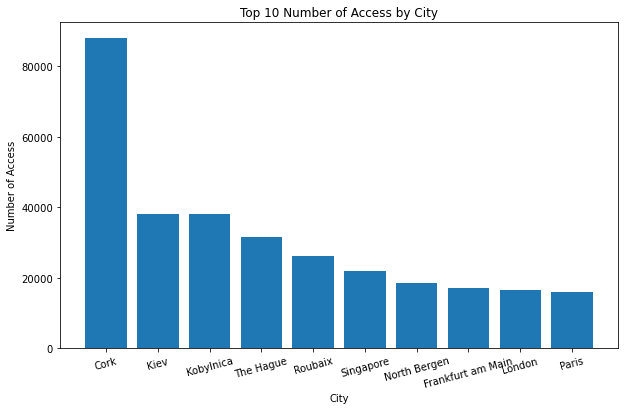

In [58]:
# plot of top 10 number of access by city
plt.figure(figsize=(10,6))
plt.bar(x = top10_city['city'], height = top10_city['count'])
plt.xlabel('City')
plt.ylabel('Number of Access')
plt.title('Top 10 Number of Access by City')
plt.xticks(rotation=15);

### world map - Tableau

### method

In [59]:
# value counts
df.method.value_counts()

POST        410095
GET         147024
HEAD          5979
CONNECT        214
OPTIONS         45
PUT             19
PROPFIND         5
ENXW             1
TROK             1
Name: method, dtype: int64

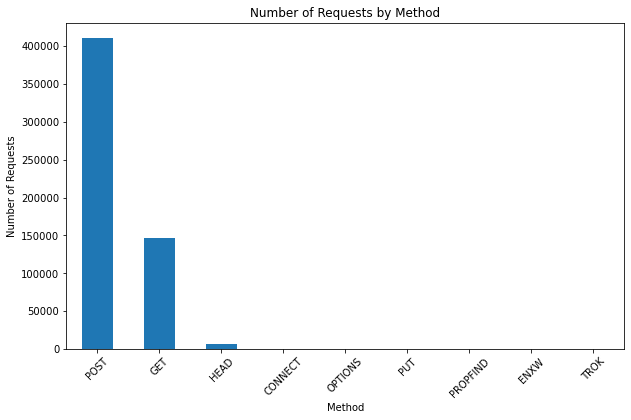

In [60]:
# bar chart of number of requests by method
plt.figure(figsize=(10, 6))
df.method.value_counts().plot(kind='bar')
plt.xlabel('Method')
plt.ylabel('Number of Requests')
plt.title('Number of Requests by Method')
plt.xticks(rotation = 45);

### http version

In [61]:
# value counts
df['http_version'].value_counts()

HTTP/1.1    560215
HTTP/1.0      3168
Name: http_version, dtype: int64

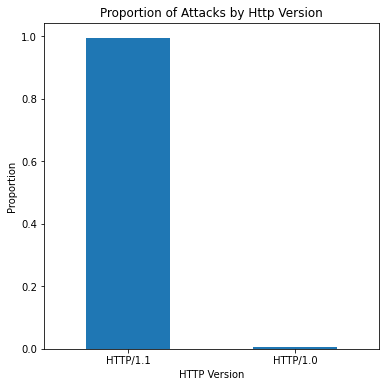

In [62]:
# bar chart of proportion of attacks by http version
plt.figure(figsize=(6, 6))
(df['http_version'].value_counts() / df.shape[0]).plot(kind = 'bar')
plt.xlabel('HTTP Version')
plt.ylabel('Proportion')
plt.title('Proportion of Attacks by Http Version')
plt.xticks(rotation = 0);

## Time Related Variables Exploration

In this part, we explore time related variables, including date, month, day, hour_JP, hour_Local

### date

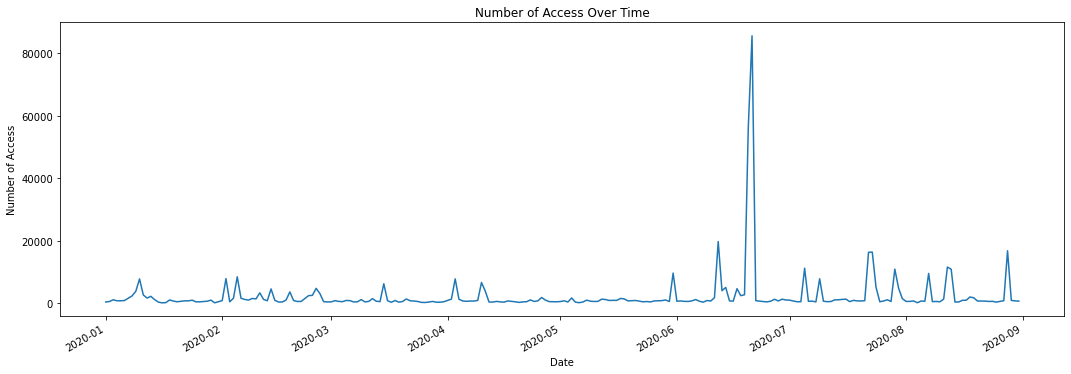

In [63]:
# line plot of access trend over time
plt.figure(figsize=(18,6))
df.date.value_counts().plot()
plt.xlabel('Date')
plt.ylabel('Number of Access')
plt.title('Number of Access Over Time')
plt.savefig('plot/1.png');
# plt.setp(plt.gca().xaxis.get_majorticklabels(),
#          'rotation', 90)
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

A peak appears at around 2020-06-21.

### month

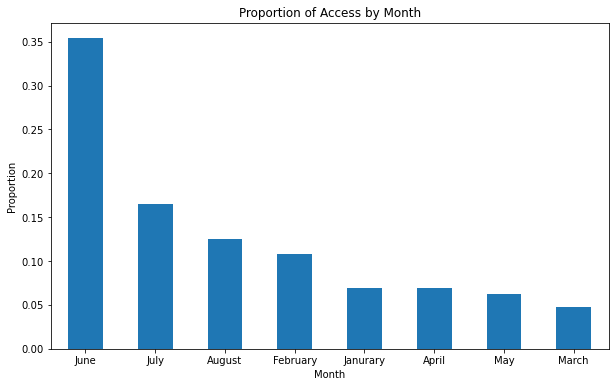

In [64]:
# bar chart
plt.figure(figsize=(10,6))
(df.month.value_counts()/df.shape[0]).plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.title('Proportion of Access by Month')
plt.xticks(rotation=0)
plt.savefig('plot/2.png');

June has the most attacks, June/July and Aug have more attacks than the other months.

In [65]:
# one way chi square test

chisq, p = chisquare(df.month.value_counts())

print('The p value is {}\n'.format(p))
if p < 0.05:
    print('p is very small, there is a significant difference')
else:
    print('p is relatively large, there is no significant difference')

The p value is 0.0

p is very small, there is a significant difference


### day

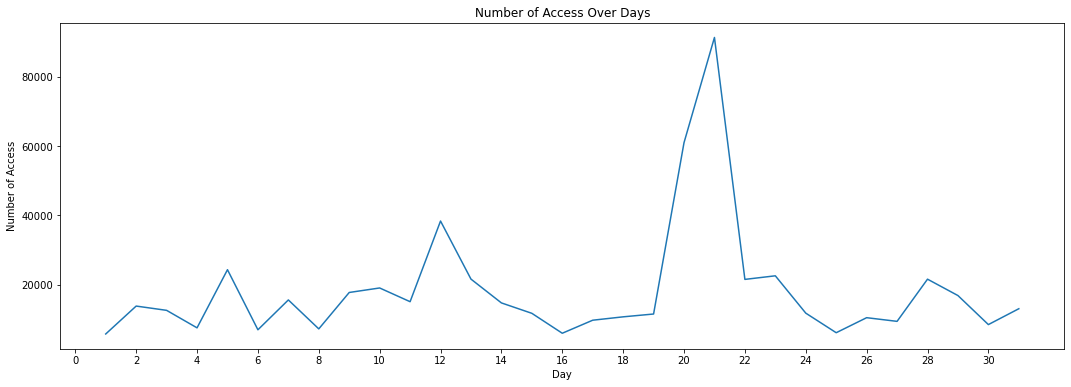

In [66]:
# plot of Number of Access Over Days
df_day = df.day.value_counts().reset_index()
df_day.columns = ['day', 'count']
plt.figure(figsize=(18, 6))
sns.lineplot(x='day', y='count', data=df_day)
plt.xlabel('Day')
plt.ylabel('Number of Access')
plt.title('Number of Access Over Days')
plt.xticks(np.arange(0, 32, 2))
plt.savefig('plot/3.png');

Overall, more attacks happen on 12 and 21.

### hour_JP

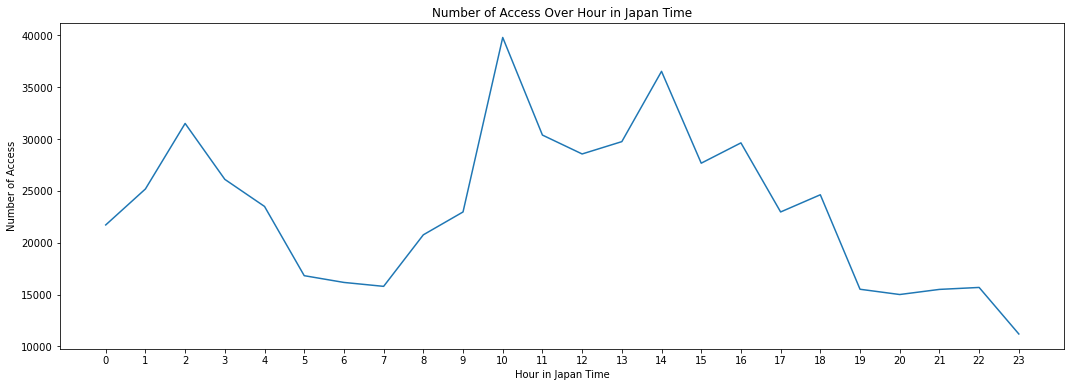

In [67]:
# plot of number of access over hour in japan time
df_hour_JP = df.hour_JP.value_counts().reset_index()
df_hour_JP.columns = ['hour_JP', 'count']
plt.figure(figsize=(18, 6))
sns.lineplot(x='hour_JP', y='count', data=df_hour_JP)
plt.xlabel('Hour in Japan Time')
plt.ylabel('Number of Access')
plt.title('Number of Access Over Hour in Japan Time')
plt.xticks(np.arange(0, 24, 1))
plt.savefig('plot/4.png');

The park appears at 2AM, 10AM and 14PM

### hour_Local

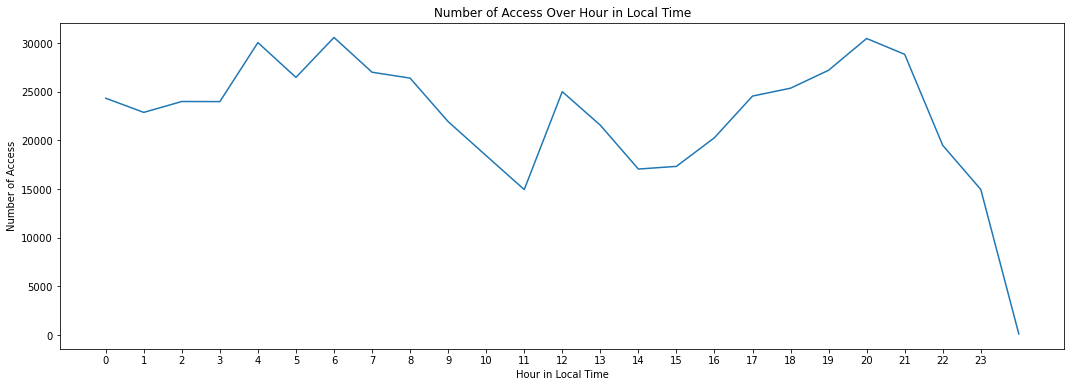

In [68]:
# plot of number of access over hour in local time
df_hour_Local = df.hour_Local.value_counts().reset_index()
df_hour_Local.columns = ['hour_Local', 'count']
plt.figure(figsize=(18, 6))
sns.lineplot(x='hour_Local', y='count', data=df_hour_Local)
plt.xlabel('Hour in Local Time')
plt.ylabel('Number of Access')
plt.title('Number of Access Over Hour in Local Time')
plt.xticks(np.arange(0, 24, 1))
plt.savefig('plot/5.png');

The peak appears at 4AM, 6AM and 20pm

### hour_Local - US

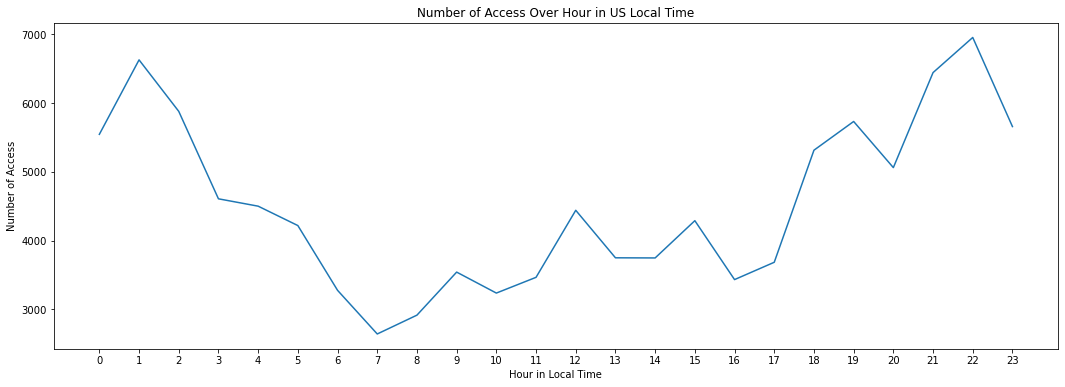

In [69]:
# plot of number of access over hour in US local time
df_hour_US_Local = df[df.country=='United States of America'].hour_Local.value_counts().reset_index()
df_hour_US_Local.columns = ['hour_Local', 'count']
plt.figure(figsize=(18, 6))
sns.lineplot(x='hour_Local', y='count', data=df_hour_US_Local)
plt.xlabel('Hour in Local Time')
plt.ylabel('Number of Access')
plt.title('Number of Access Over Hour in US Local Time')
plt.xticks(np.arange(0, 24, 1))
plt.savefig('plot/11.png');

For attacks from US, the peaks are at 1AM and 22PM

### hour_Local - Ireland

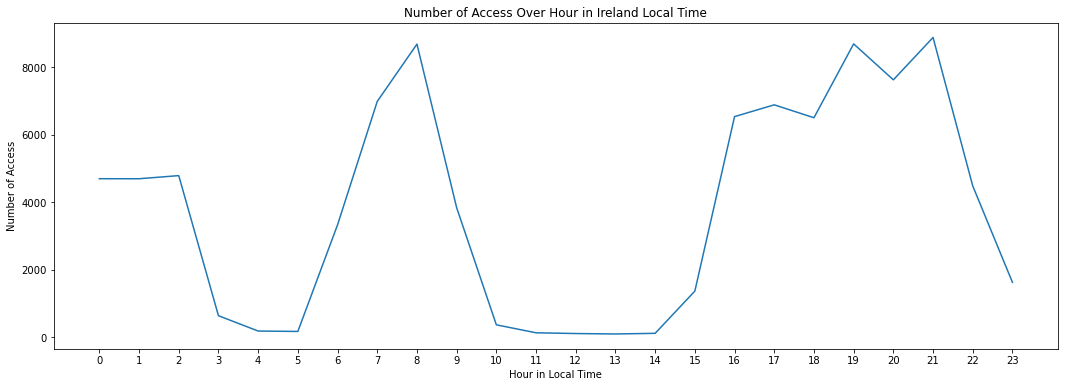

In [70]:
# plot of number of access over hour in Ireland local time
df_hour_Ireland_Local = df[df.country=='Ireland'].hour_Local.value_counts().reset_index()
df_hour_Ireland_Local.columns = ['hour_Local', 'count']
plt.figure(figsize=(18, 6))
sns.lineplot(x='hour_Local', y='count', data=df_hour_Ireland_Local)
plt.xlabel('Hour in Local Time')
plt.ylabel('Number of Access')
plt.title('Number of Access Over Hour in Ireland Local Time')
plt.xticks(np.arange(0, 24, 1))
plt.savefig('plot/12.png');

For attacks from Ireland, the peaks appear at 8AM, 19PM and 21PM

## Location Related Variables Exploration

In this part, we explore location related variables, including ip_country, country, city

### ip_country

In [71]:
# top 10 IPs
df.groupby(['ip_country', 'country']).size().sort_values(ascending=False).head(10)

ip_country          country    
185.234.216.28-IE   Ireland        45191
185.234.217.39-IE   Ireland        42428
193.106.30.99-UA    Ukraine        37926
193.169.252.37-PL   Poland         37913
80.82.70.206-NL     Netherlands    10444
185.39.10.73-CH     Switzerland     9280
94.102.49.7-NL      Netherlands     8840
185.128.41.50-CH    Switzerland     7116
122.114.57.92-CN    China           6840
222.170.170.196-CN  China           5952
dtype: int64

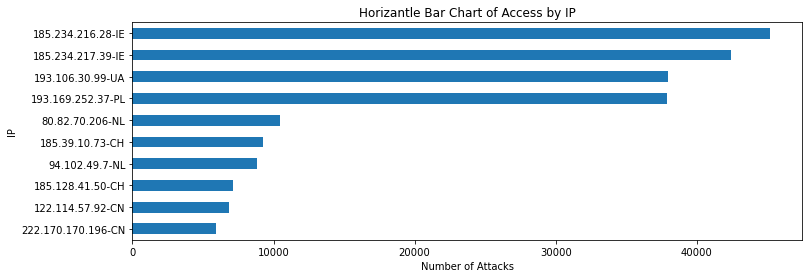

In [72]:
# bar chart of top 10 IPs
plt.figure(figsize=(12, 4))
df.ip_country.value_counts().head(10).sort_values().plot(kind='barh')
plt.xlabel('Number of Attacks')
plt.ylabel('IP')
plt.title('Horizantle Bar Chart of Access by IP')
plt.savefig('plot/6.png');

### country

In [73]:
# top 10 country
df_country = df.country.value_counts().reset_index()
df_country.columns = ['country', 'count']
top10_country = df_country.iloc[0:10, ]
top10_country.at[0, 'country'] = 'US'
top10_country.at[9, 'country'] = 'UK'
top10_country

,country,count
0,US,108978
1,Ireland,91565
2,France,44303
3,Netherlands,42770
4,Poland,41847
5,Ukraine,39682
6,Germany,26578
7,China,24729
8,Singapore,22071
9,UK,18940


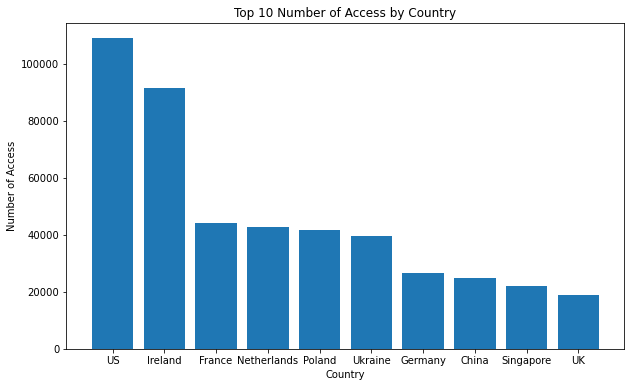

In [74]:
# plot of top 10 number of access by country
plt.figure(figsize=(10,6))
plt.bar(x = top10_country['country'], height = top10_country['count'])
plt.xlabel('Country')
plt.ylabel('Number of Access')
plt.title('Top 10 Number of Access by Country')
plt.savefig('plot/7.png');

### city

In [75]:
# top 10 city
df_city = df.city.value_counts().reset_index()
df_city.columns = ['city', 'count']
top10_city = df_city.iloc[0:10, ]
top10_city

,city,count
0,Cork,88017
1,Kiev,37985
2,Kobylnica,37977
3,The Hague,31504
4,Roubaix,26215
5,Singapore,22071
6,North Bergen,18417
7,Frankfurt am Main,17266
8,London,16537
9,Paris,15948


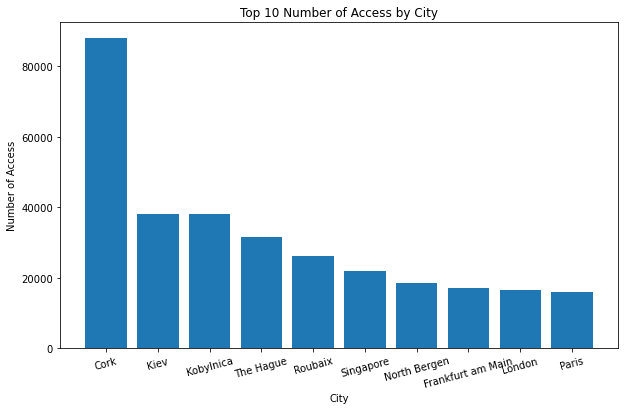

In [76]:
# plot of top 10 number of access by city
plt.figure(figsize=(10,6))
plt.bar(x = top10_city['city'], height = top10_city['count'])
plt.xlabel('City')
plt.ylabel('Number of Access')
plt.title('Top 10 Number of Access by City')
plt.xticks(rotation=15)
plt.savefig('plot/8.png');

## Technique Related Variables Exploration

In this part, we explore technique related variables, including method and http_version

### method


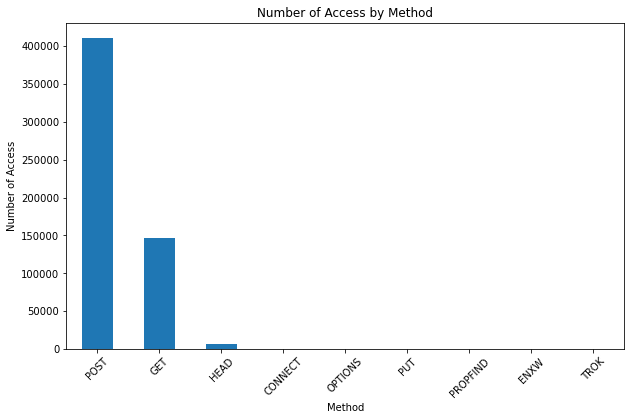

In [77]:
# bar chart of number of requests by method
plt.figure(figsize=(10, 6))
df.method.value_counts().plot(kind='bar')
plt.xlabel('Method')
plt.ylabel('Number of Access')
plt.title('Number of Access by Method')
plt.xticks(rotation = 45)
plt.savefig('plot/9.png');

### http_version

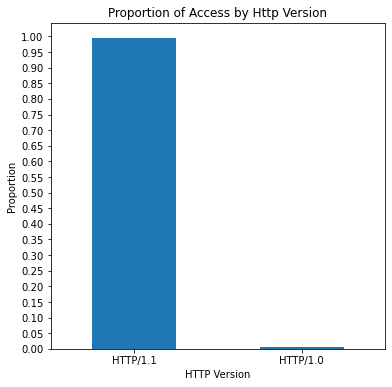

In [78]:
# bar chart of proportion of attacks by http version
plt.figure(figsize=(6, 6))
(df['http_version'].value_counts() / df.shape[0]).plot(kind = 'bar')
plt.xlabel('HTTP Version')
plt.ylabel('Proportion')
plt.title('Proportion of Access by Http Version')
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.savefig('plot/10.png');

In [79]:
# export the dataframe as csv file
df.to_csv('data/honeypot.csv')

## Reference

- [IP2Location™ LITE IP-COUNTRY-REGION-CITY-LATITUDE-LONGITUDE-ZIPCODE-TIMEZONE Database](https://lite.ip2location.com/database/ip-country-region-city-latitude-longitude-zipcode-timezone)
- [ValueError: invalid literal for int() with base 10](https://stackoverflow.com/questions/1841565/valueerror-invalid-literal-for-int-with-base-10)
- [python pandas- apply function with two arguments to columns](https://stackoverflow.com/questions/34279378/python-pandas-apply-function-with-two-arguments-to-columns)